In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

In [48]:
%matplotlib inline

### Import dataset:

In [49]:
df = pd.read_csv('./dataset/dataset-uci.csv')
print('shape', df.shape)
df.head()

shape (319, 39)


,Gallstone Status,Age,Gender,Comorbidity,Coronary Artery Disease (CAD),Hypothyroidism,Hyperlipidemia,Diabetes Mellitus (DM),Height,Weight,...,High Density Lipoprotein (HDL),Triglyceride,Aspartat Aminotransferaz (AST),Alanin Aminotransferaz (ALT),Alkaline Phosphatase (ALP),Creatinine,Glomerular Filtration Rate (GFR),C-Reactive Protein (CRP),Hemoglobin (HGB),Vitamin D
0,0,50,0,0,0,0,0,0,185,92.8,...,40.0,134.0,20.0,22.0,87.0,0.82,112.47,0.0,16.0,33.0
1,0,47,0,1,0,0,0,0,176,94.5,...,43.0,103.0,14.0,13.0,46.0,0.87,107.10,0.0,14.4,25.0
2,0,61,0,0,0,0,0,0,171,91.1,...,43.0,69.0,18.0,14.0,66.0,1.25,65.51,0.0,16.2,30.2
3,0,41,0,0,0,0,0,0,168,67.7,...,59.0,53.0,20.0,12.0,34.0,1.02,94.10,0.0,15.4,35.4
4,0,42,0,0,0,0,0,0,178,89.6,...,30.0,326.0,27.0,54.0,71.0,0.82,112.47,0.0,16.8,40.6


In [50]:
# print(df.columns)

### Check for missing values:

In [51]:
if df.isnull().values.any():
  print("There are missing values in the dataset.")
else:
  print("There are no missing values in the dataset.")

There are no missing values in the dataset.


### Check for recundancy

Check for duplicate rows or collumns.

In [52]:
duplicate_rows = df.duplicated().sum()
duplicate_collumns = df.T.duplicated().sum()
print("duplciate rows: ", duplicate_rows)
print("duplicate columns: ", duplicate_collumns)

duplciate rows:  0
duplicate columns:  0


Check for irrelevant  features.

In [53]:
constant_features = [col for col in df.columns if df[col].nunique() <=1]
print("Contant features: ", constant_features)

low_variance_features = [col for col in df.columns if df[col].var() < 0.01]
print("Low variance features: ", low_variance_features)

Contant features:  []
Low variance features:  []


Check for highly correlated features.

In [54]:
corr_matrix = df.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

high_correlation = [(col, row, upper.loc[row, col])
                    for col in upper.columns
                    for row in upper.index
                    if upper.loc[row, col] > 0.9]


print("Highly correlated feature pairs (correlation > 0.9):")
for col, row, correlation in high_correlation:
    print(col, "<->", row, "correlation: " ,"{:.3f}".format(correlation))

Highly correlated feature pairs (correlation > 0.9):
Extracellular Water (ECW) <-> Total Body Water (TBW) correlation:  0.904
Lean Mass (LM) (%) <-> Total Body Fat Ratio (TBFR) (%) correlation:  0.994
Muscle Mass (MM) <-> Total Body Water (TBW) correlation:  0.929
Muscle Mass (MM) <-> Intracellular Water (ICW) correlation:  0.904
Total Fat Content (TFC) <-> Body Mass Index (BMI) correlation:  0.903


Question: Should we do something about the highly correlated values? (Drop one of two features?)

### Check for Outliers: (Should we drop the outliers from the dataset?)

In [55]:
for col in df.select_dtypes(include='number'):
    # Skip binary columns (only 0 and 1 values)
    if set(df[col].dropna().unique()) <= {0, 1}:
        continue
    
    Q1, Q3 = df[col].quantile([0.1, 0.90])
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    outlier_count = ((df[col] < lower) | (df[col] > upper)).sum()
    
    if outlier_count > 0:
        print(f"{col}: {outlier_count} outliers")

Comorbidity: 2 outliers
Intracellular Water (ICW): 1 outliers
Obesity (%): 1 outliers
Visceral Fat Area (VFA): 1 outliers
Glucose: 12 outliers
High Density Lipoprotein (HDL): 1 outliers
Triglyceride: 3 outliers
Aspartat Aminotransferaz (AST): 5 outliers
Alanin Aminotransferaz (ALT): 5 outliers
Alkaline Phosphatase (ALP): 1 outliers
Glomerular Filtration Rate (GFR): 3 outliers
C-Reactive Protein (CRP): 12 outliers


Visualization of features with higher number of outliers:

Text(0.5, 1.0, 'C-Reactive Protein (CRP)')

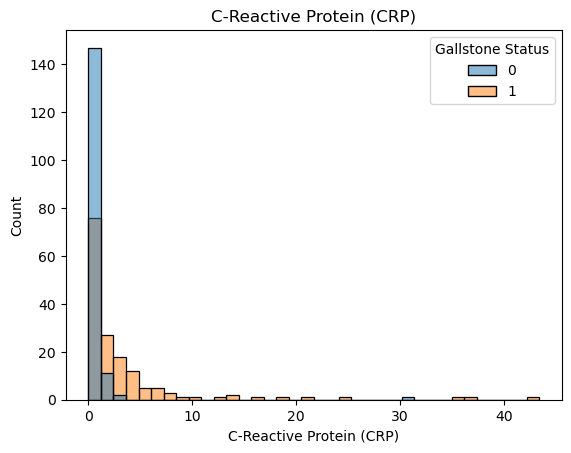

In [56]:
sbn.histplot(data=df, x='C-Reactive Protein (CRP)', hue='Gallstone Status')
plt.title('C-Reactive Protein (CRP)')

Text(0.5, 1.0, 'Glucose')

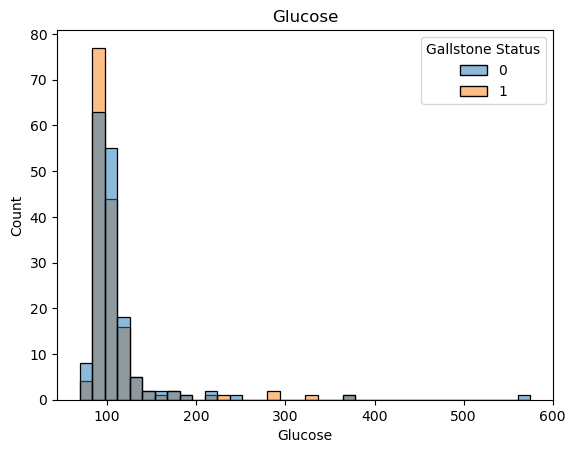

In [57]:
sbn.histplot(data=df, x='Glucose', hue='Gallstone Status')
plt.title('Glucose')

### Visualization

Age vs Gallstone Status:

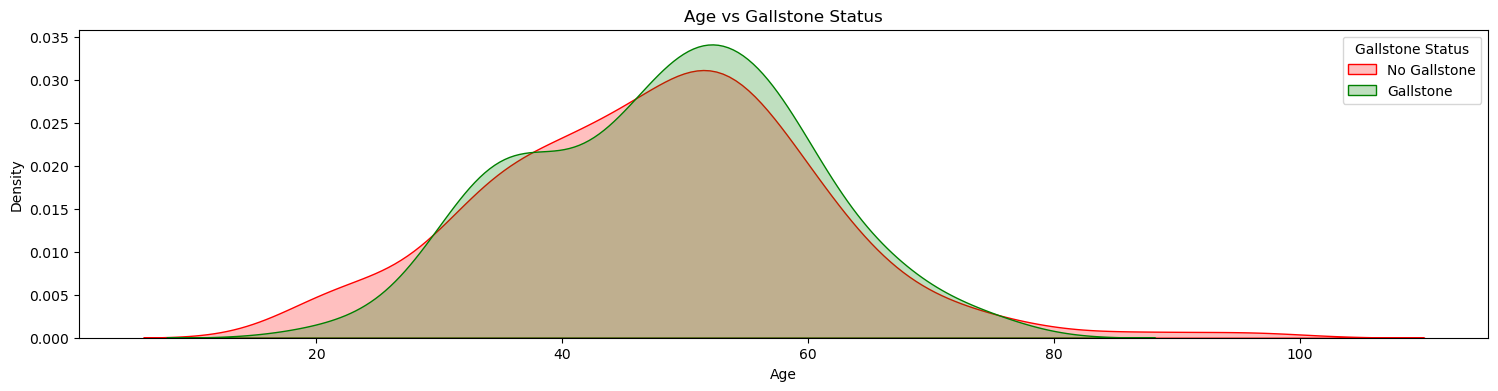

In [58]:
fig = plt.figure(figsize=(40,4))
ax = fig.add_subplot(1, 2, 1)
sbn.kdeplot(df['Age'][df['Gallstone Status'] == 0], color='red', fill=True, ax=ax, label='No Gallstone')
sbn.kdeplot(df['Age'][df['Gallstone Status'] == 1], color='green', fill=True, ax=ax, label='Gallstone')
ax.set_title('Age vs Gallstone Status')
ax.legend(title='Gallstone Status', loc='upper right')

Gender vs Gallstone Status:

Text(0.5, 1.0, 'Gender vs Gallstone Status')

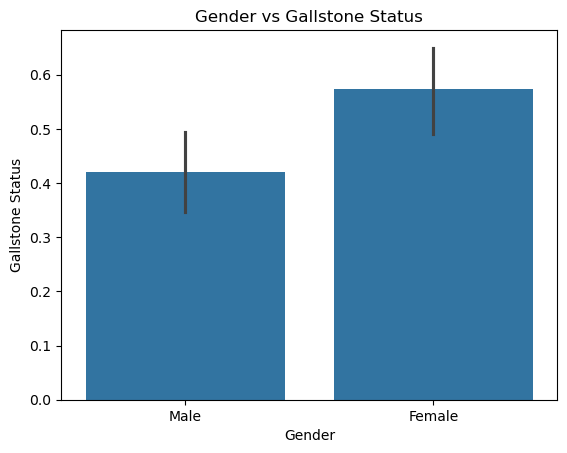

In [59]:
ax = sbn.barplot(data=df, x='Gender', y='Gallstone Status')

ax.set_xticks([0, 1])
ax.set_xticklabels(['Male', 'Female'])
plt.title('Gender vs Gallstone Status')

Comorbidity vs Gallstone Status

Text(0.5, 1.0, 'Comorbidity vs Gallstone Status')

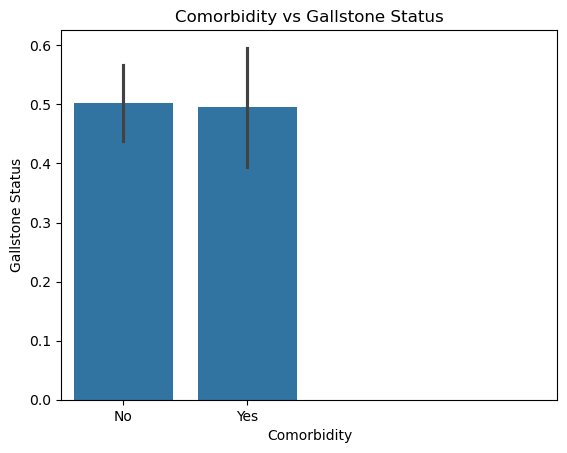

In [60]:
ax = sbn.barplot(data=df, x='Comorbidity', y='Gallstone Status')

ax.set_xticks([0, 1])
ax.set_xticklabels(['No', 'Yes'])
plt.title('Comorbidity vs Gallstone Status')

Coronary Artery Disease (CAD) vs Gallstone Status

Text(0.5, 1.0, 'Coronary Artery Disease (CAD) vs Gallstone Status')

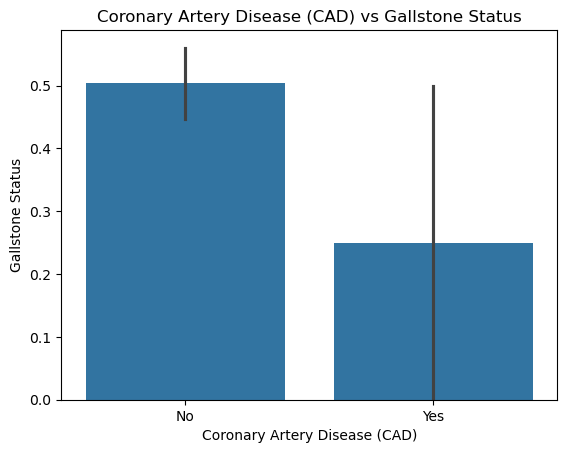

In [61]:
ax = sbn.barplot(data=df, x='Coronary Artery Disease (CAD)', y='Gallstone Status')

ax.set_xticks([0, 1])
ax.set_xticklabels(['No', 'Yes'])
plt.title('Coronary Artery Disease (CAD) vs Gallstone Status')

Height vs Gallstone Status

<Axes: xlabel='Height', ylabel='Density'>

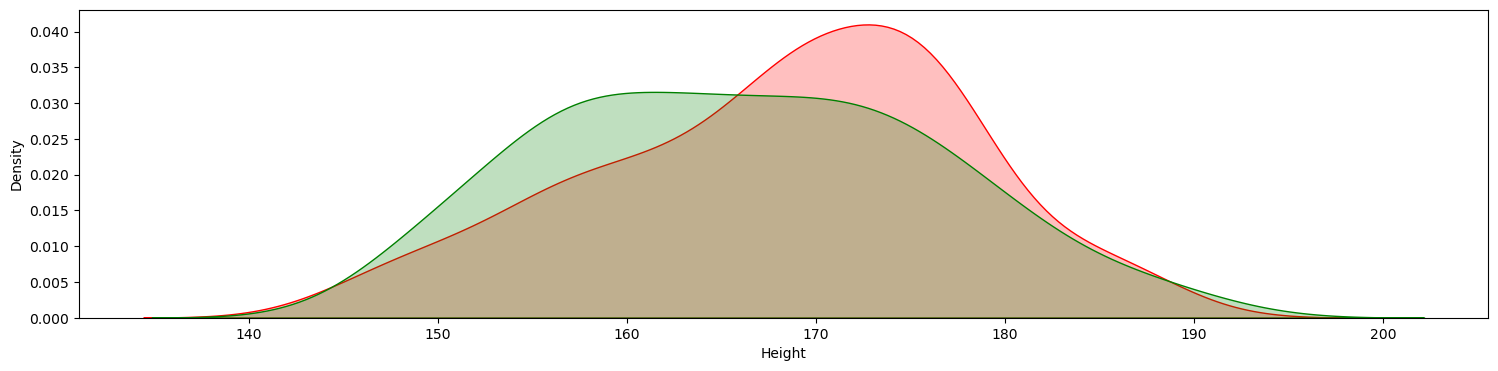

In [62]:
fig = plt.figure(figsize=(40,4))
ax = fig.add_subplot(1, 2, 1)
sbn.kdeplot(df['Height'][df['Gallstone Status'] == 0], color='red', fill=True, ax=ax)
sbn.kdeplot(df['Height'][df['Gallstone Status'] == 1], color='green', fill=True, ax=ax)

Weight vs Gallstone Status:

<Axes: xlabel='Weight', ylabel='Density'>

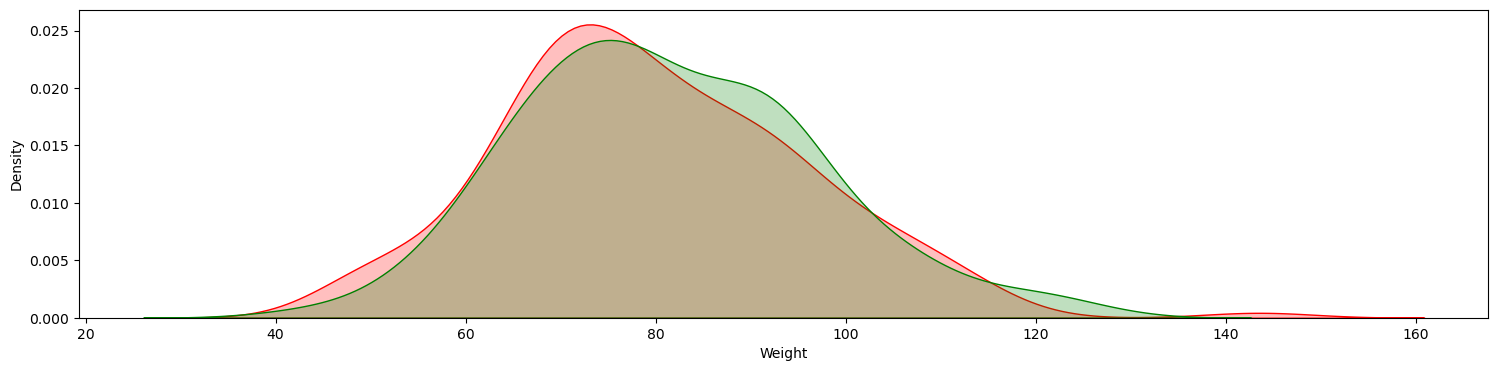

In [63]:
fig = plt.figure(figsize=(40,4))
ax = fig.add_subplot(1, 2, 1)
sbn.kdeplot(df['Weight'][df['Gallstone Status'] == 0], color='red', fill=True, ax=ax)
sbn.kdeplot(df['Weight'][df['Gallstone Status'] == 1], color='green', fill=True, ax=ax)

Hepatic Fat Accumulation (HFA) vs Gallstone Status

Text(0.5, 1.0, 'Hepatic Fat Accumulation (HFA) vs Gallstone Status')

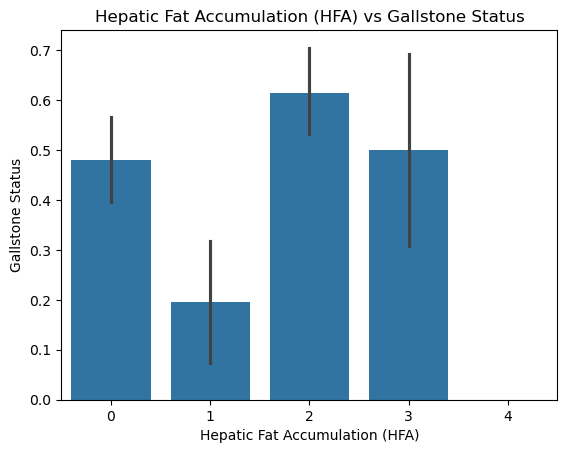

In [64]:
sbn.barplot(data=df, x='Hepatic Fat Accumulation (HFA)', y='Gallstone Status')
plt.title('Hepatic Fat Accumulation (HFA) vs Gallstone Status')

Age distribution in gender groups: (Is something like this useful?)

Text(0.5, 0.98, 'Age distribution in gender groups')

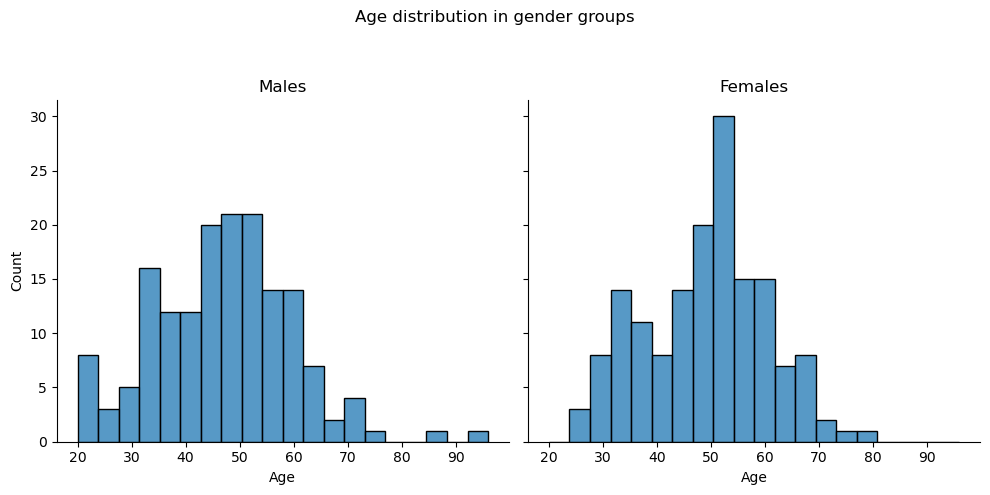

In [65]:
g = sbn.displot(data=df, x='Age', col='Gender', bins=20, kde=False)

g.axes[0, 0].set_title("Males")
g.axes[0, 1].set_title("Females")

plt.subplots_adjust(top=0.8)
g.figure.suptitle('Age distribution in gender groups')


Correlation Heatmap:

Text(0.5, 1.0, 'Features with Correlation > 0.8')

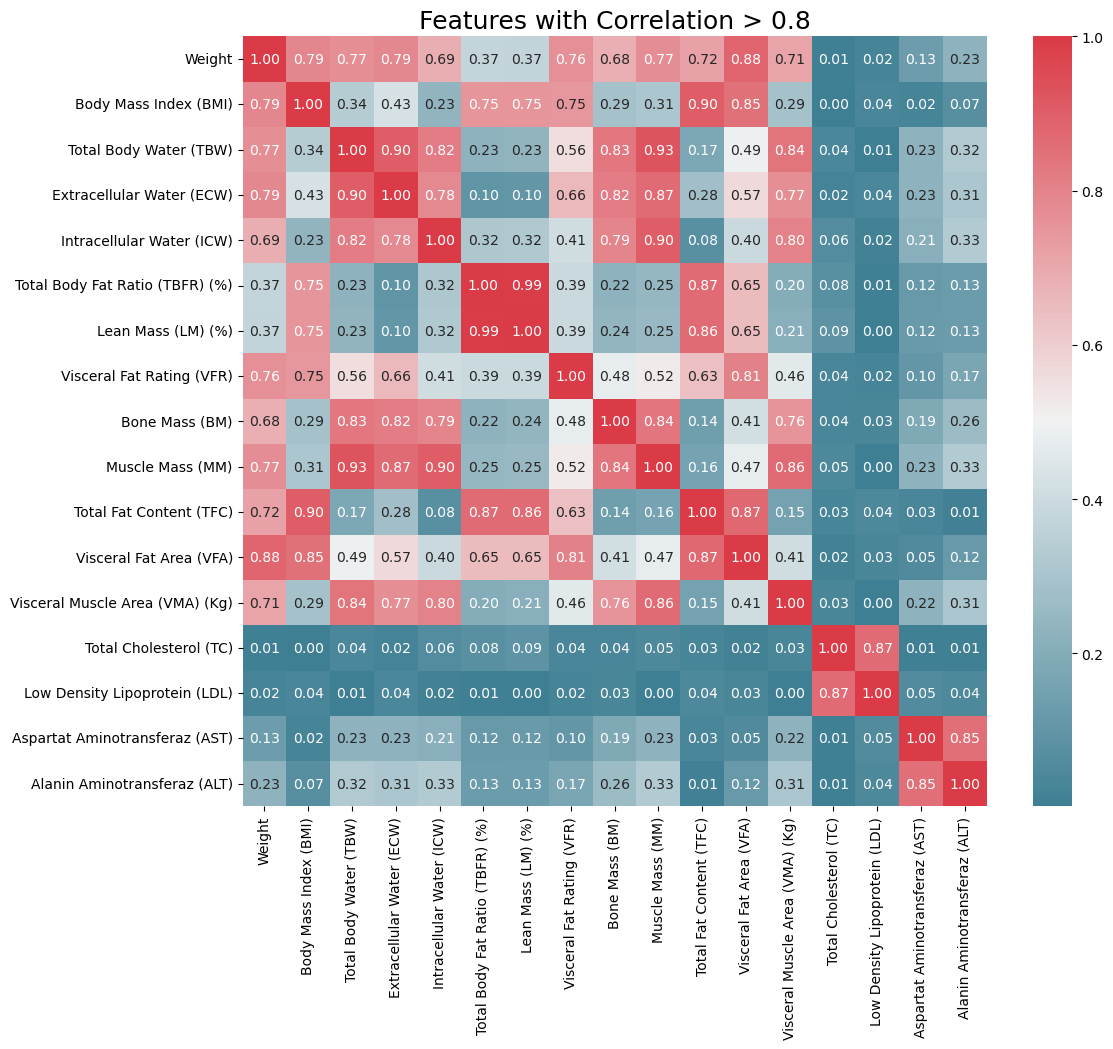

In [66]:
corr_matrix = df.corr().abs()
# set diagonal to 0
corr_matrix_no_diagonal = corr_matrix.copy()
np.fill_diagonal(corr_matrix_no_diagonal.values, 0) 
# select features that reach a threshold of correlation
min_correlation_features = corr_matrix_no_diagonal.columns[(corr_matrix_no_diagonal > 0.8).any()]
filtered_corr_matrix = corr_matrix.loc[min_correlation_features, min_correlation_features]

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(1,1,1)
colormap = sbn.diverging_palette(220, 10, as_cmap=True)
sbn.heatmap(filtered_corr_matrix, cmap=colormap, annot=True, fmt=".2f", ax=ax)
plt.title(f"Features with Correlation > 0.8", fontsize=18)

### k-nearest neighbors

In [78]:
# split data (80% train, 20% test)
X = df.drop('Gallstone Status', axis=1)
y = df['Gallstone Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Feature count: {X_train.shape[1]}")
print(f"Class distribution in training: {y_train.value_counts().to_dict()}")

# standardize the features, as KNN is distance-based and sensitive to scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Training set: 255 samples
Test set: 64 samples
Feature count: 38
Class distribution in training: {0: 129, 1: 126}


In [81]:
# find optimal number of neighbors (k) using cross-validation
k_range = range(1, 21)
cv_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

optimal_k = k_range[np.argmax(cv_scores)]
print("Optimal k:", optimal_k)

knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train_scaled, y_train)

Optimal k: 11


,n_neighbors,11
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [82]:
y_pred = knn.predict(X_test_scaled)
y_proba = knn.predict_proba(X_test_scaled)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.734375
ROC-AUC: 0.767578125

Confusion Matrix:
 [[30  2]
 [15 17]]

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.94      0.78        32
           1       0.89      0.53      0.67        32

    accuracy                           0.73        64
   macro avg       0.78      0.73      0.72        64
weighted avg       0.78      0.73      0.72        64

